# Homework 4 - Hard coding

![alt text](https://scontent-fco2-1.xx.fbcdn.net/v/t1.6435-9/p640x640/184205866_309950770525058_7072329262818108856_n.jpg?_nc_cat=101&ccb=1-5&_nc_sid=e3f864&_nc_ohc=NV-BDW8fI68AX-nKfZT&_nc_ht=scontent-fco2-1.xx&oh=d9a93541fee5ec4b8999dcaac221d921&oe=61AE1128)

# VERY VERY IMPORTANT!

1. !!! Read the entire homework before coding anything!!!

2. My solution it's not better than yours, and yours is not better than mine. In any data analysis task, there is not a unique way to solve a problem. For this reason, it is crucial (necessary and mandatory) that you describe any single decision you take and all the steps you do.

3. Once performed any exercise, comments about the obtained results are mandatory. We are not always explicit about where to focus your comments, but we will always want some brief sentences about your discoveries and decisions.

## 1. Implementing your own Shazam 

[Shazam](https://www.shazam.com/) is a great application that can tell you the title of a song by listening to a short sample. For this task, you will implement a simplified copy of this app by dealing with hashing algorithms. In particular, you will implement your [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/) that takes as input an audio track and finds relevant matches.

![myshazam](https://www.codeproject.com/KB/WPF/duplicates/conceptialoverview.png)

### 1.1 Getting your data!

1) Download the [dataset](https://www.kaggle.com/dhrumil140396/mp3s32k) from Kaggle. 

2) We have prepared some query songs which we would like to know the title of. You can download them from here:
- [query1](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track1.wav)
- [query2](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track2.wav)
- [query3](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track3.wav)
- [query4](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track4.wav)
- [query5](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track5.wav)
- [query6](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track6.wav)
- [query7](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track7.wav)
- [query8](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track8.wav)
- [query9](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track9.wav)
- [query10](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track10.wav)

3) Now you can convert the tracks in the dataset from mp3 format to wav format. We have prepared some utility functions for this. Read the instructions in point 1.2.

### 1.2 Fingerprint hashing
We want to create a representation of our audio signal that allows us to characterize it with respect to its peaks. If you are new to audio signal processing, we recommend that you read [this introductory article](https://willdrevo.com/fingerprinting-and-audio-recognition-with-python/). It will allow you to understand this task much better. Once this process is complete, we can adopt a hashing function to get a fingerprint of each song.

To help you in the extraction phase of the audio signal we have written some utility functions for you that you can find in `AudioSignals.ipynb`. To use them you will need to install (FFMPEG)[https://www.ffmpeg.org/] and [Librosa](https://librosa.org/doc/latest/index.html) in your environment. Of course, you are free to experiment and try any other audio representation you think is best.

In [9]:
import numpy as np      
import matplotlib.pyplot as plt 
import subprocess
import librosa
import librosa.display
import pandas as pd
import random

from pathlib import Path
from tqdm.notebook import tqdm

## Utility functions

In [10]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure(figsize=(20, 5))
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)
        

    return track, sr, onset_env, peaks
    
    

## Settings

In [11]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [12]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [13]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## Audio signals

data/mp3s-32k/metallica/Metallica/10-The_God_that_Failed.wav
n_peaks:
64


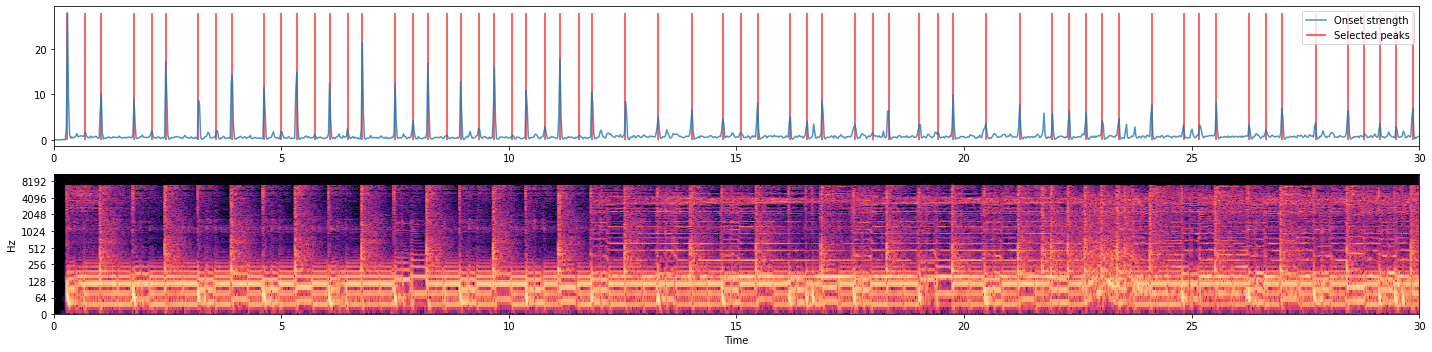

data/mp3s-32k/metallica/Metallica/09-Of_Wolf_and_Man.wav
n_peaks:
58


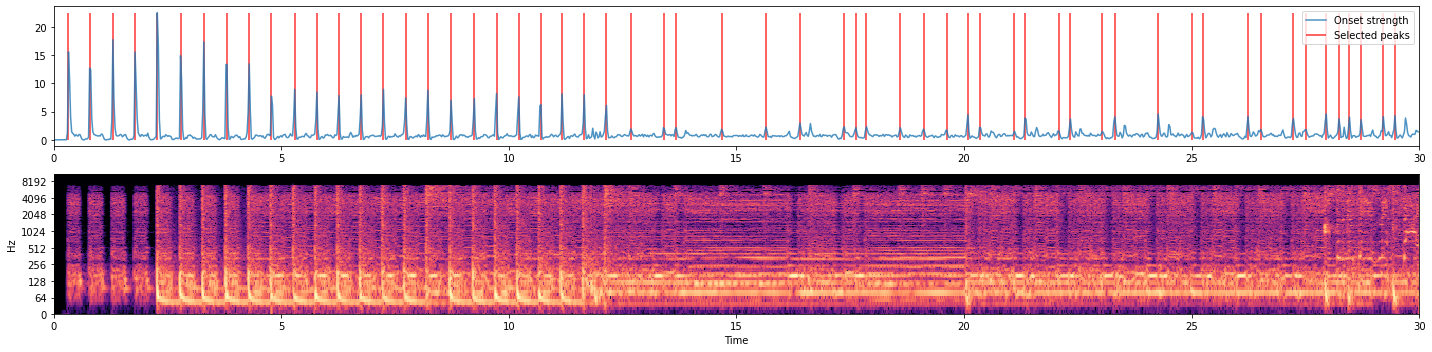

In [14]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    print(audio)
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    print(f"n_peaks:\n{len(peaks)}")
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)
        
        

## Handling the data

In order to work with the songs we've made function usefull to process the information that we have and reduce the number of calling to heavy processes

### Saving elaborated data

In order to work repeatedly with the processed songs and query we've made a functions that transforms either the songs or the queryes to a dataframe.

In the case of the songs, the dataframes we'll have as columns ```['title', 'author', 'album', 'peaks']```<br>
Instead for the queries only ```['query', 'peaks']``` where query will be the name 'query01' or 'query02' and so on, this happens 'cause at this step we don't have the real values for title, album and author of the songs

In order to save the queries, they will be first converted as maw format. The queries are then be modified by hand adding the real title author and album


### Retrieving saved data
Now we can retrieve the stored data without recompute it from scratch each time we need them.<br>
The last processing functions is made exactly for this intent


In [15]:
def create_tracks_dataframe(track_names, query=False, tot_tracks=0):
    if not query:
        ret = pd.DataFrame(columns=['title', 'author', 'album', 'peaks'])
    else: 
        ret = pd.DataFrame(columns=['query', 'peaks'])
    
    for track_path in tqdm(track_names, str(tot_tracks)):

        if not query:
            _, _, author, album, title = str(track_path).split('/')
        else:
            _, _, title = str(track_path).split('/')
        title = title.split('.')[0]
        title = title[title.find('-')+1:]
        _, _, _, peaks = load_audio_picks(track_path, DURATION, HOP_SIZE)
        ret.loc[len(ret)] = [title] + ([author, album] if not query else []) + [peaks]
    return ret

In [16]:
tracks = data_folder.glob("*/*/*.wav")
#tracks_df = create_tracks_dataframe(tracks, tot_tracks = N_TRACKS)

In [17]:
query_folder = Path("data/queries/")
mp3_queries = query_folder.glob("*.mp3")
for track in tqdm(mp3_queries, total=10):
    convert_mp3_to_wav(str(track))


  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
mav_queryes = query_folder.glob("*.wav")
queries_df = create_tracks_dataframe(list(mav_queryes), query=True)

0:   0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
import ast
def read_songs_df(fpath='data/songs_db.csv'):
    tmp = pd.read_csv(fpath, header='infer')
    tmp.peaks = tmp.peaks.apply(ast.literal_eval)
    return tmp

# Now it's your turn!

1) Implement your minhash function  **from scratch**. *No ready-made hash functions are allowed*. Read the class material and search the internet if you need to. As a reference, it may be useful to look at the description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf).

2) Read the dataset sequentially and add it to your MinHash. The aim is to make your minhash function map the same song to the same bins. You can define a threshold to control the accuracy of these matches. For example, if you want your app to suggest songs similar to the query one, you can vary the threshold accordingly. Experiment with at least 3 different values and report the results.

3) You are given 10 *query tracks*, report their title!

## Minhash

# Some Theory
Before go ahead with the implementation of MinHash let's dig into the description of what we are looking for.<br>
Suppose to have two sets $S_1$ and $S_2$ and to want to compute how much they are similar. Then the function that you're looking for is the *Jaccard similarity* that's given by the formula: 
\begin{equation}
    J(S_1, S_2) = \frac{|S_1 \cap S_2|}{|S_1 \cup S_2|}
\end{equation}
Given that compute this value is so much expensive in terms of computation, we're looking for a different representation of sets and their similarity, here comes to our aid the **MinHash** function.

Let's dig into it!<br>

## Set representation
For the aim of this discussion let's imagine a set represented by a sort of one-hot matrix, suppose that the alphabet that we are working with is made by the set {a, b, c, d, e, f} and $S_1 = \{a, b, e, f\}$  and  $S_2 = \{a, c, f\}$.

We can represent this information by the table that follows:
| Elements  | S_1  | S_2 |
|---|---|---|
| a | 1 | 1 |
| b | 1 | 0 |
| c | 0 | 1 |
| d | 0 | 0 |
| e | 1 | 0 |
| f | 1 | 1 |

Computing the jaccard similarity we have $J(S_1,S_2) = \frac{2}{6}$ given that we have two elements in common (a and f) and 6 elements in total.

What can MinHash do? Well, to ask ad this let's make a preliminar version of the minhash function that simply permutes the row of that table and takes for each set the element for which we have the first one on the set's column:
| Elements  | S_1  | S_2 |
|---|---|---|
| c | 0 | 1 |
| f | 1 | 1 |
| a | 1 | 1 |
| d | 0 | 0 |
| e | 1 | 0 |
| b | 1 | 0 |

So we will have $minHash(S_1)=f$ and $minHash(S_2)=c$.<br>
But what's the connection with jaccard? Well, the connection is that the probability to get $minHash(S_1)==minHash(S_2)$ is exactly this similarity value.<br>
I mean, the event $J_h$=\{minHash(S_1)==minHash(S_2)\}$ is described by meet a row with a double one before than a row with only one one.<br>
Intuitivelly the rows with all zeros can be ignored, so we have two tipes of rows: 
* $t_1$ that has two ones
* $o_1$ that has only one one
Give this information we can simply note that the probability to pick a $t_1$ row is given by:
\begin{equation}
    \frac{|t_1|}{|t_1| + |o_1|}
\end{equation}
But this sets are exactly the intersection and the union of this sets, so we have that two documents get the same minHash with probability equal to their jaccard similarity

Given that the cardinality of a set can be huge, we can use h(s) to create a signature of the set, in particular if we execute $n$ permutation and we compute for each permutation the minhasch, for each set we'll have n values, these n values will be the signature of that set.

Suppose to have the erlier permutation and to have these other two permutations:

| Elements  | S_1  | S_2 |
|---|---|---|
| a | 1 | 1 |
| b | 1 | 0 |
| c | 0 | 1 |
| f | 1 | 1 |
| d | 0 | 0 |
| e | 1 | 0 |


| Elements  | S_1  | S_2 |
|---|---|---|
| f | 1 | 1 |
| c | 0 | 1 |
| a | 1 | 1 |
| b | 1 | 0 |
| d | 0 | 0 |
| e | 1 | 0 |


we have that for permutation 1, 2 and 3 respectivelly, the minhash values are the follows:
\begin{align*}
    h_1(S_1) &= f\\
    h_2(S_1) &= a\\
    h_3(S_1) &= f\\
    h_1(S_2) &= c\\
    h_2(S_2) &= a\\
    h_3(S_2) &= f
\end{align*}

So the three characters signatures are:<br>
$sig(S_1) =$ faf<br>
$sig(S_2) =$ caf

## Example:
Let's see it by a simple code example:

In [20]:
import numpy as np
import random

def hashed_jaccard(sig1, sig2):
    return np.sum(sig1==sig2)/len(sig1)

def real_jaccard(s1, s2):
    return len((s1.intersection(s2)))*1.0/len(s1.union(s2))

def foo_min_hash(s, perm):
    """ 
        Given a document s and a list of permutations, this functions compute the earlier definition of min_hash
    """
    for p in perm:
        if p in s:
            return p
    return None

def estimate_jaccard(s1, s2, sign_len):
    """ 
        Given two documents as set of integers, and a signature length this method computes 
        the two signatures and the jaccard similarity estimated from that, so returns
        the estimated jaccard similarity and a tuple containing the two signatures
    """


    alphabet = list(s1.union(s2))
    sig1 = []
    sig2 = []
    for _ in range(sign_len):
        perm = np.random.permutation(alphabet)
        sig1.append(foo_min_hash(s1,perm))
        sig2.append(foo_min_hash(s2,perm))

    sig1= np.array(sig1)
    sig2= np.array(sig2)
    return round(hashed_jaccard(sig1, sig2),3), (sig1, sig2)

    


In [21]:
s1 = set(random.choices(range(1000), k=700))
s2 = set(random.choices(range(1000), k=700))
cum=[]
sigs = []
n_sim = 100.0
for i in range(int(n_sim)):
    prob, sig = estimate_jaccard(s1, s2, 10)
    sigs.append(sig)
    cum.append(prob)
print(f"mean_permutation_jaccards: {round(sum(cum)/n_sim,3)}")
print(f"real_jaccard: {real_jaccard(s1,s2)}")
print(f"signatures: \n")
for s in range(10):
    print(f"\tsignature1: {sigs[s][0]} signature2: {sigs[s][1]}")



mean_permutation_jaccards: 0.345
real_jaccard: 0.3390052356020942
signatures: 

	signature1: [ 54 459 112  14 214 793 255 952 167 422] signature2: [788 769 112 601 988 385  17 494 582 527]
	signature1: [253 675 667 289 497 840 460 214 497 249] signature2: [ 73 306 667  30 391 840 479 555 251 249]
	signature1: [875 398 587 595  91 706 299 112 131 747] signature2: [875 653 141 595 853 644 778 112 716 747]
	signature1: [703 537 309 439 803 214 149 583 489 583] signature2: [703 382 782 439 170 104 149  16 823 583]
	signature1: [505 588 669 512 194 325 624 909 371 289] signature2: [475 588 806 348 396 835 624 909 371 345]
	signature1: [119 655 444 870 802 531 329 122 678 566] signature2: [708 417 249 647 802 727 523 298 405 566]
	signature1: [843 870  60 370 593 445 268 496 675 869] signature2: [583 118 449 370 602 445 946  35 819 742]
	signature1: [626 830 911  91 355 256 268 556 179 280] signature2: [653 276 911 541 355 157 268 600 707 197]
	signature1: [ 91 104 993 325 371 748 380 139 79

## Real MinHash
We've implemented a simple minhash, but we can't actually use it given that for big alphabet even the calcolus of the permutation can be huge, so we'll replace it with the calculation of the hash, but let's go in more details...<br>

The object of our desire is a matrix that for each hash function (that is replacing the above permutations) has a single hash value for each column (representing the set), we'll call this matrix $SIG$ and its dimension is $nxC$ where n is the number of hash functions and C is the number of the sets that we're comparing.<br>

Let's fill it!<br>
```
for each row r:
  compute $h_1(r)$, $h_2(r)$, ..., $h_n(r)$<br>
    for each column $c$:<br>
      if c has 0 in r: 
        continue
      else:
        for each i in range(n):
          SIG(i, c) = min(SIG(i, c), h_i(r))
```

So that's why this algorithm is called Min hash, for each column (set) we're taking the minimum hash value of the elements that it contains.

In [22]:
def create_hash_func(a, b, n):
    return lambda x: ((x*a)+b)%n

def min_hash(s1, hash_f):
    return min(map(hash_f, s1))

def estimate_jaccard_hash(s1, s2, sign_len):
    """ 
        Given two documents as set of integers, and a signature length this method computes 
        the two signatures and the jaccard similarity estimated from that, so returns
        the estimated jaccard similarity and a tuple containing the two signatures
    """

    n=4294967311 # first prime bigger than 2^32 discovered by: https://github.com/chrisjmccormick/MinHash/edit/master/runMinHashExample.py
    sig1 = []
    sig2 = []
    hash_functions = [create_hash_func(random.randint(1, n-1), random.randint(1, n-1), n) for _ in range(sign_len)]
    for i in range(sign_len):
        sig1.append(min_hash(s1,hash_functions[i]))
        sig2.append(min_hash(s2,hash_functions[i]))

    sig1= np.array(sig1)
    sig2= np.array(sig2)
    return round(hashed_jaccard(sig1, sig2),3), (sig1, sig2)

In [23]:
cum=[]
sigs = []
n_sim = 100.0
for i in range(int(n_sim)):
    prob, sig = estimate_jaccard_hash(s1, s2, 10)
    sigs.append(sig)
    cum.append(prob)
print(f"mean_hashed_jaccards: {round(sum(cum)/n_sim,3)}")
print(f"real_jaccard: {real_jaccard(s1,s2)}")
print(f"signatures: \n")
for s in range(3):
    print(f"\tsignature1: {sigs[s][0]} signature2: {sigs[s][1]}")

mean_hashed_jaccards: 0.329
real_jaccard: 0.3390052356020942
signatures: 

	signature1: [ 2055896 26353783 19345417   836209   870508  3736620 11331260 18129040
 13842160  1008693] signature2: [ 2055896 24846160 20779993   836209  6151614  4326846 26523569  7186869
  8043200  1008693]
	signature1: [2504911 3628112 1188079  375927 2217708  553320 2819755  500044 8126445
 6864243] signature2: [ 2504911 12133901  1188079   375927   891646  2839331  2819755   500044
  8126445  6864243]
	signature1: [78838484  2208607 23858036  2409022 17177609  4024871  7855602   129433
  4734001 13335666] signature2: [78838484 16366285 25303130  6441275 25927635  4165507  7855602   129433
   394568  5349669]


## LSH

Well! We've done the min hash and it seems that performs well, we've compared it with the real jaccard similarity and with the permutated min hash, but now we need to make the last step in order to compare efficiently our documents.

Given that comparing each query with each document requires a huge amount of time and resources, we can think to compare the queries only with the songs that are similar to them, but wait... What does it mean **similar**?

Well remembering that our signature is a sequence of application of different hash function on two sets and that this reduce the real dimension to the sets to the dimension of the signature and that the number of equal values for the **same** hash function divided by the signature lenght suggests us a good approximation of the jaccard similarity, its not absurd to think that documents or sets with equal **part of signature** can be similar.

Let's explain it with an example

Suppose to have the sets S1, S2, S3 and that they have the signature:
SIG(S1) = 11223131
SIG(S2) = 12456900
SIG(S3) = 12223531

At first glance the S2 has not so in common with the other two but S1 and S3 are so similar, how can we compare only them?<br>
imagining the hash table we have:
| S_1 | S_2  | S_3 |
|---|---|---|
| 1 | 1 | 1 |
| 1 | 2 | 2 |
| 2 | 4 | 2 |
| 2 | 5 | 2 |
| 3 | 6 | 3 |
| 1 | 9 | 5 |


Now imagine to divide it in $b$ bins each of $r$ rows, for example 3 bins of 2 rows
| S_1 | S_2  | S_3 |
|---|---|---|
| 1 | 1 | 1 |
| 1 | 2 | 2 |
|---|---|---|
| 2 | 4 | 2 |
| 2 | 5 | 2 |
|---|---|---|
| 3 | 6 | 3 |
| 1 | 9 | 5 |

As can be easily seen $S_1$ and $S_2$ ave several bin in common.
Hence the idea of LSH is to compare not all the pairs of documents but only the documents that have at least one bin in common.

### Algorithm

```
    INPUT: list of documents, a query, r
    Output: list of documents similar to the query (sorted)

    hashed_documents = [min_hash(document) for each document in input]
    hashed_query = min_hash(query)
    index = {(i,r row of document signature): [documents that has those rows in the i-th position of their signature]}
    similar_docs = []
    for i in len(hashed_query.splitted_every_r_rows):
        key = (i, hashed_query.splitted_every_r_rows[i])
        similar_docs.append(index[key]) # if exists
    
    return similar_docs.sorted(by estimated similarity in descending order)


```


In [24]:
def get_parameters(n, threshold=None):
    ''' 
        Given the max lenght of the signature
        returns the number of bins and rows for the LSH algorithm.
        if n is a prime number, subtracts one as long as can find a divisible number
    '''
    threshold = round(threshold, 1) if threshold is not None else None
    for b in range(2, n):
        if (n%b)==0:
            r = n//b
            t = round((1/b)**(1.0/r), 1)
            if threshold is None:
                t = round((b)**(-1*(1.0/r)), 1)
                return b, r

            elif t == threshold:
                return b, r

    if n >1:
        return get_parameters(n-1, threshold)
    return None, None

def create_buckets(hash_sets, r):
    """ 
        Given a set with all the documents's signatures this function builds a dictionary that acts as an index.
        The keys are the r-th elements of all signatures and the values are the lists of document that have that signature in that position
    """
    ret = dict()
    n_hash = len(hash_sets[0])
    for hs in range(len(hash_sets)):
        sig = hash_sets[hs]
        for i in range(0, n_hash,r):
            k = (i, str(sig[i:i+r]))
            if k not in ret:
                ret[k] = [hs]
            else:
                ret[k].append(hs)
    return ret

def create_signature(doc, hash_functions):
    """ 
        Given a document and a list of hash functions it returns the signature of that document
    """
    sig = []
    for hf in hash_functions:
        sig.append(min_hash(doc, hf))
    return np.array(sig)


def LSH(documents, sig_len, query=None, query_list=None, threshold = None):
    """ 
        This is the LSH algorithm that runs for each query in a list of query or for a single query.
        If it's passed a list of query is more efficient than call this method multiple times with different query
        because of the computation of the indexes.
        The algorithm takes as parameter the maximum signature length and eventually a treshold.
        It's possible that the given threshold is not feasible with the given signature lenght so it'll be used a smaller one.

        The function returns a list of list where for each query there's a list of similar document sorted by their estimated
        jaccard similarity
        and returns the used threshold and signature lenght since they can differ from the input ones
    """

    if query is None and query_list is None: # cheking the user input
        raise ValueError("you must give me a query or a query list")
    if query is not None: 
        query_list = [query]
    
    # Obtaining the number of bins (b) and the number of rows for each one (r)
    b, r = get_parameters(sig_len, threshold)
    if b is None:
        print(f"impossible find a value for threshold {threshold}")
        b, r = get_parameters(sig_len)
    if (b*r) < sig_len:
        print(f"in order to reach threshold= {threshold} sig_len has to be {b*r}")
        sig_len = b*r
    threshold = round(b**(-1.0/r), 1)
    print(f"b: {b}, r: {r},  threshold: {threshold}, sig_len: {b*r}")
    n = 4294967311 # biggest prime number after 2^32

    # Now all the parameter are fixed and it's time to compute the hash of the queries and the documents
    hash_functions = [create_hash_func(random.randint(1,n-1),random.randint(1, n-1),(n)) for _ in range(sig_len)]
    hashed_docs = list(map(lambda d: create_signature(d, hash_functions), documents))
    hashed_queries = list(map(lambda query: create_signature(query, hash_functions), query_list))

    # Retrueving the index
    idx = create_buckets(hashed_docs, r)

    # Obtaining for each query its list of similar document
    similar_docs = [set() for _ in hashed_queries]
    ret = [[] for _ in hashed_queries]
    for i in range(len(hashed_queries)):
        hashed_query = hashed_queries[i]
        for j in range(0, sig_len, r):
            k = (j,str(hashed_query[j:j+r]))
            if k in idx:
                similar_docs[i] = similar_docs[i].union(idx[k])
        for doc in similar_docs[i]:
            hashed_jacc = hashed_jaccard(hashed_docs[doc], hashed_query)
            ret[i].append((doc, hashed_jacc)) # Sorting for the estimated jaccard similarity
        ret[i] = sorted(ret[i], key=lambda x: -x[1])
    return ret, threshold, sig_len

In [25]:
def test_different_thresholds(queries_df, tracks_df):
    """ 
        Given a list of queries it returns a dataframe containing the number of the interested query, the leng of the signature
        the threshold and the number of similar item toghether with the estimated title author and album of the query.
        taking the value of interest from the input dataframes
    """
    evaluation_df = pd.DataFrame(columns=['query_number', 'sig_len', 'threshold', 'number_similar', 'title', 'author', 'album'])
    queries = queries_df.peaks.values
    for th in range(1,6):
        th /=10.0
        th_ans, threshold, sig_len = LSH(tracks_df.peaks, 50, query_list=queries, threshold=th)
        for i in range(len(queries)):
            data = tracks_df.iloc[th_ans[i][0][0]]
            evaluation_df.loc[len(evaluation_df)] = [i, sig_len, threshold, len(th_ans[i]), data.title, data.author, data.album]
        print()
    return evaluation_df

In [26]:
def get_named_answers(answers, query_df, song_df):
    """ 
        Given a list of list containing the most similar songs for each query, this function
        prints the real query information and the estimated ones taking these values from the input dataframes
    """
    for i in range(len(answers)):
        query = query_df.iloc[i]
        song = song_df.iloc[answers[i][0][0]]
        print(f"Estimated: {query.query} title: {query.title} author: {query.author} album: {query.album}")
        print(f"Real: {song.title} author: {song.author} album: {song.album}")
        print()

# Analizyng the threshold's effects:

Now that we've all the ingredients in order to find the answers to our queries, let's first analyze what happen changing the value of the threshold.

Given that for values greater than 0.5 we've the same effect ad for threshold equal to one, I've experimented only with lower values.
The first step is load the datasets of the queries and songs created above in order to avoid usefull computations

In [27]:
tracks_df = read_songs_df('data/songs_db.csv')
tracks_df

,title,author,album,peaks
0,The_God_that_Failed,metallica,Metallica,"[13, 30, 45, 76, 93, 106, 137, 154, 169, 199, ..."
1,Of_Wolf_and_Man,metallica,Metallica,"[14, 34, 56, 77, 98, 120, 142, 164, 185, 206, ..."
2,Dont_Tread_on_Me,metallica,Metallica,"[15, 30, 63, 78, 111, 158, 173, 206, 220, 254,..."
3,Nothing_Else_Matters,metallica,Metallica,"[13, 32, 50, 67, 86, 105, 122, 141, 159, 177, ..."
4,My_Friend_of_Misery,metallica,Metallica,"[14, 25, 47, 57, 68, 90, 101, 133, 145, 166, 1..."
...,...,...,...,...
1408,Let_Me_Entertain_You,queen,Jazz,"[16, 31, 59, 72, 99, 113, 140, 154, 182, 195, ..."
1409,Fat_Bottomed_Girls_1991_Remix_,queen,Jazz,"[15, 71, 100, 116, 129, 144, 159, 180, 217, 23..."
1410,Dead_On_Time,queen,Jazz,"[14, 37, 162, 203, 317, 367, 479, 517, 532, 56..."
1411,Fun_It,queen,Jazz,"[13, 36, 49, 60, 71, 83, 94, 106, 118, 128, 14..."


In [28]:
queries_df = read_songs_df('data/total_queries.csv')
queries_df


,query,peaks,title,author,album
0,query01,"[15, 34, 50, 67, 84, 100, 116, 132, 150, 167, ...",Dream_On,aerosmith,Aerosmith
1,query02,"[17, 29, 41, 52, 64, 76, 88, 100, 111, 124, 13...",I_Want_To_Break_Free,queen,The_Works
2,query03,"[25, 56, 73, 145, 176, 193, 266, 296, 312, 385...",October,u2,October
3,query04,"[10, 43, 54, 64, 75, 86, 99, 110, 123, 133, 14...",Ob-La-Di_Ob-La-Da,beatles,The_White_Album_Disc_1
4,query05,"[12, 49, 84, 103, 119, 154, 190, 210, 225, 261...",Karma_Police,radiohead,OK_Computer
5,query06,"[11, 44, 73, 100, 128, 155, 185, 212, 236, 249...",Heartbreaker,led_zeppelin,Led_Zeppelin_II
6,query07,"[20, 49, 67, 96, 115, 144, 163, 183, 203, 221,...",Go_Your_Own_Way,fleetwood_mac,Rumours
7,query08,"[17, 40, 52, 67, 80, 101, 114, 129, 142, 170, ...",American_Idiot,green_day,American_Idiot
8,query09,"[16, 447, 706, 718, 734, 974, 1022, 1049, 1074...",Somebody,depeche_mode,Some_Great_Reward
9,query10,"[52, 71, 84, 97, 110, 130, 150, 162, 210, 230,...",Black_Friday,steely_dan,Katy_Lied


In [29]:
queries = queries_df.peaks.values
multiple_threshold_ans = test_different_thresholds(queries_df, tracks_df)

impossible find a value for threshold 0.1
b: 2, r: 25,  threshold: 1.0, sig_len: 50

b: 25, r: 2,  threshold: 0.2, sig_len: 50

in order to reach threshold= 0.3 sig_len has to be 30
b: 15, r: 2,  threshold: 0.3, sig_len: 30

in order to reach threshold= 0.4 sig_len has to be 48
b: 16, r: 3,  threshold: 0.4, sig_len: 48

in order to reach threshold= 0.5 sig_len has to be 48
b: 12, r: 4,  threshold: 0.5, sig_len: 48



In [30]:
multiple_threshold_ans.groupby('threshold').agg({'number_similar':'mean'})

,number_similar
threshold,
0.2,29.2
0.3,12.8
0.4,1.8
0.5,1.0
1.0,1.0


As can be seen the threshold that spots the most similar song in absolute is the threshold with value equal to 1, so let's use it to answer to the question!

In [31]:
answers, _, _ = LSH(tracks_df.peaks, 50, query_list=queries, threshold=1)

b: 2, r: 25,  threshold: 1.0, sig_len: 50


In [32]:
get_named_answers(answers, queries_df, tracks_df)

Estimated: query01 title: Dream_On author: aerosmith album: Aerosmith
Real: Dream_On author: aerosmith album: Aerosmith

Estimated: query02 title: I_Want_To_Break_Free author: queen album: The_Works
Real: I_Want_To_Break_Free author: queen album: The_Works

Estimated: query03 title: October author: u2 album: October
Real: October author: u2 album: October

Estimated: query04 title: Ob-La-Di_Ob-La-Da author: beatles album: The_White_Album_Disc_1
Real: Ob-La-Di_Ob-La-Da author: beatles album: The_White_Album_Disc_1

Estimated: query05 title: Karma_Police author: radiohead album: OK_Computer
Real: Karma_Police author: radiohead album: OK_Computer

Estimated: query06 title: Heartbreaker author: led_zeppelin album: Led_Zeppelin_II
Real: Heartbreaker author: led_zeppelin album: Led_Zeppelin_II

Estimated: query07 title: Go_Your_Own_Way author: fleetwood_mac album: Rumours
Real: Go_Your_Own_Way author: fleetwood_mac album: Rumours

Estimated: query08 title: American_Idiot author: green_day al

Now let's analyze what happens with similar songs and not only with songs that are equals to the query, we'll use the threshold value 0.4 since it in average keeps 1.6 similar songs for each query

In [33]:
similar, _, _ = LSH(tracks_df.peaks, 50, query_list=queries, threshold=.4)

in order to reach threshold= 0.4 sig_len has to be 48
b: 16, r: 3,  threshold: 0.4, sig_len: 48


In [34]:
titles = queries_df.title

In [35]:
for i in range(10):
    print(f"the query {i}-th with title: {titles.iloc[i]} has {len(similar[i])} similar songs:")
    for sim in similar[i]:
        ans = tracks_df.iloc[sim[0]]
        print(f"\t\"{ans.title.replace('_', ' ')}\" of the author {ans.author} in the album {ans.album} with jaccard sim: {real_jaccard(set(queries[i]), set(ans.peaks))}")

the query 0-th with title: Dream_On has 1 similar songs:
	"Dream On" of the author aerosmith in the album Aerosmith with jaccard sim: 1.0
the query 1-th with title: I_Want_To_Break_Free has 1 similar songs:
	"I Want To Break Free" of the author queen in the album The_Works with jaccard sim: 1.0
the query 2-th with title: October has 1 similar songs:
	"October" of the author u2 in the album October with jaccard sim: 1.0
the query 3-th with title: Ob-La-Di_Ob-La-Da has 2 similar songs:
	"Ob-La-Di Ob-La-Da" of the author beatles in the album The_White_Album_Disc_1 with jaccard sim: 1.0
	"Something In The Water Does Not Compute " of the author prince in the album 1999 with jaccard sim: 0.05521472392638037
the query 4-th with title: Karma_Police has 2 similar songs:
	"Karma Police" of the author radiohead in the album OK_Computer with jaccard sim: 1.0
	"Going Down-Love In An Elevator" of the author aerosmith in the album Pump with jaccard sim: 0.05660377358490566
the query 5-th with title: 

# 2. Grouping songs together!

We play with a dataset gathering songs from the International Society for Music Information Retrieval Conference. The tracks (songs) include much information. We focus on the **track information**, **features** (extracted with [librosa](https://librosa.org/)  library from Python) and **audio variables** provided by Echonest (now Spotify). 

*The final goal is to group songs into similar genres, therefore **DO NOT** use the feature genre in your k-means anaylsis*

To solve this task, you must accomplish the next stages:

### 2.1 Getting your data!

1) Access to the data can be found here:

 - [echonest.csv](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/echonest.csv)
 - [features.csv](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/features.csv)
 - [tracks.csv](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/tracks.csv)

2) Data Scientists are often challenged to do Data Wrangling. The latter is a process of cleaning and unifying messy and complex data sets for easy access and analysis ([see more info here](https://www.altair.com/what-is-data-wrangling/)). You are supposed to create one single data set by merging **tracks.csv**, **features.csv** and **echonest.csv**. It's your job to find the correct *key* to join your data sets together. You should end up with a data set of ~13K rows.

## Data wrangling
Now that we've these three datasets I'm going to analyse and merge it

In [36]:
import pandas as pd
echo = pd.read_csv('data/csv/echonest.csv')
print("Read echo")
tracks = pd.read_csv('data/csv/tracks.csv')
print("Read tracks")
features = pd.read_csv('data/csv/features.csv')
print("Read features")

Read echo
Read tracks
Read features


### Analysis of the datasets
In order to find the right key where we can merge, let's explore the datasets that we are facing with.<br>
These datasets are all in csv format and have very much colums, so for each datasets I've first analyzed the general info, then obtained the columns with nan values inside it and, at the end I've evaluated if these datasets contains some duplicates

Let's start with the first:
#### Echonest

In [37]:
echo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB


In [38]:
none_echo = echo.isna().sum()
none_echo[none_echo>0]

metadata_album_date              10412
metadata_album_name              10257
metadata_artist_latitude          3359
metadata_artist_location          3359
metadata_artist_longitude         3359
ranks_artist_discovery_rank      10304
ranks_artist_familiarity_rank    10304
ranks_artist_hotttnesss_rank     10305
ranks_song_currency_rank         11096
ranks_song_hotttnesss_rank       10923
dtype: int64

In [39]:
len(echo)-len(echo.drop_duplicates())

0

So:<br>
Echonest.csv has 13129 entries and 250 columns, 10 of them contains nan values and there aren't duplicates

#### Tracks

In [40]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        103045 non-null  object 
 3   album_date_released       70294 non-null   object 
 4   album_engineer            15295 non-null   object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         83149 non-null   object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            18060 non-null   object 
 10  album_tags                106574 non-null  object 
 11  album_title               105549 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                100066 non-null  o

In [41]:
none_tracks = tracks.isna().sum()
print(len(none_tracks[none_tracks>0]))
none_tracks[none_tracks>0]

28


album_date_created            3529
album_date_released          36280
album_engineer               91279
album_information            23425
album_producer               88514
album_title                   1025
album_type                    6508
artist_active_year_begin     83863
artist_active_year_end      101199
artist_associated_labels     92303
artist_bio                   35418
artist_date_created            856
artist_latitude              62030
artist_location              36364
artist_longitude             62030
artist_members               59725
artist_related_projects      93422
artist_website               27318
artist_wikipedia_page       100993
track_composer              102904
track_date_recorded         100415
track_genre_top              56976
track_information           104225
track_language_code          91550
track_license                   87
track_lyricist              106263
track_publisher             105311
track_title                      1
dtype: int64

In [42]:
len(tracks)-len(tracks.drop_duplicates())

0

So:<br>
Tracks has 28 columns with nan value (one of which is the title), in total has 53 columns and 106574 distinct rows

#### Features

In [43]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


In [44]:
none_features = features.isna().sum()
none_features[none_features>0]

Series([], dtype: int64)

In [45]:
len(features)-len(features.drop_duplicates())

0

So:<br>
Features has 519 columns and no one of them has nan values, it has 106574 distinct rows

Let's now try to understand which is the most suitable attributes to use as joint key, intuitively all of these datasets has the **'track_id'** attribute, it's an ID, so maybe it'll be our field, but let's investigate a bit

In [46]:
echo.keys()[np.where(echo.nunique()==len(echo))]

Index(['track_id', 'audio_features_danceability', 'audio_features_energy',
       'audio_features_speechiness', 'temporal_features_074',
       'temporal_features_078', 'temporal_features_099',
       'temporal_features_127', 'temporal_features_171',
       'temporal_features_172', 'temporal_features_178',
       'temporal_features_194', 'temporal_features_199',
       'temporal_features_210'],
      dtype='object')

In [47]:
tracks.keys()[np.where(tracks.nunique()==len(tracks))]

Index(['track_id'], dtype='object')

In [48]:
features.keys()[np.where(features.nunique()==len(features))]

Index(['track_id'], dtype='object')

In [49]:
set(features.keys()).intersection(set(tracks.keys())).intersection(set(echo.keys()))

{'track_id'}

It's pretty clear that the field of above is the one that is unique in all three datasets, so it's the unique field that can be used as key, it's also the most usefull one and the **most important** is that it's the unique field common between the three datasets.

So now we've to select the keys common to the three datasets and pick, from each dataset the subset of entries that has this set of keys.

In [50]:
len(set(features.track_id).intersection(set(tracks.track_id)).intersection(set(echo.track_id)))

13129

In [51]:
len(echo.track_id)

13129

It seems that we will pick all the keys that are in the echo dataset

In [52]:
total_dataset = pd.merge(pd.merge(echo, tracks, how='left', on='track_id'), features, how='left', on='track_id')

In [53]:
total_dataset.info() # we expect 820 columns that are 250 echo +  53 tracks + 519 features - 2 track_id

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 820 entries, track_id to zcr_std_01
dtypes: float64(764), int64(16), object(40)
memory usage: 82.2+ MB


In [54]:
total_dataset.head(2)

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330


In [55]:
out_path = 'data/csv/total_dataset.csv'
if not os.path.exists(out_path):
    total_dataset.to_csv(out_path, index=False)

### 2.2.1 choose your features

First of all we want to understand the structure of the dataset to understand the most important features

In [11]:
import numpy as np
import pandas as pd

In [12]:
df = pd.read_csv('data/csv/total_dataset.csv')

/Users/alessandro/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (292,297,299) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 820 entries, track_id to zcr_std_01
dtypes: float64(764), int64(16), object(40)
memory usage: 82.1+ MB


In [ ]:
df.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623


In [ ]:
df.describe()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
count,13129.000000,1.312900e+04,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,9770.000000,...,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000
mean,34031.058268,5.246876e-01,0.487290,0.537516,0.640536,0.187804,0.099174,123.080061,0.439761,39.961892,...,0.098148,0.020808,0.021015,25.018749,0.390947,0.054220,0.045464,0.002278,3.045043,0.039537
std,28950.422182,3.837186e-01,0.190148,0.278049,0.361430,0.158051,0.137381,35.015137,0.276028,15.554275,...,0.033604,0.005486,0.005382,50.457231,0.174132,0.025987,0.024935,0.003833,2.522266,0.023510
min,2.000000,9.035000e-07,0.051307,0.000020,0.000000,0.025297,0.022324,12.753000,0.000010,-45.867100,...,0.025852,0.007120,0.007083,-1.497076,0.034180,0.003505,0.000000,0.000000,-1.899091,0.002749
25%,12986.000000,1.037726e-01,0.344759,0.321300,0.323466,0.101406,0.036932,95.967000,0.197321,37.784827,...,0.073244,0.016876,0.017138,3.887364,0.268555,0.037313,0.028809,0.000000,1.466201,0.023241
50%,28097.000000,5.739848e-01,0.485635,0.549113,0.838134,0.119002,0.049019,120.057000,0.417743,40.781400,...,0.093910,0.019855,0.020120,10.089380,0.372070,0.050600,0.041504,0.000000,2.412807,0.033872
75%,45021.000000,9.207270e-01,0.629094,0.776254,0.918244,0.211041,0.085452,145.318000,0.665575,47.254575,...,0.118866,0.023813,0.023981,25.418970,0.465820,0.066101,0.057129,0.003418,3.853693,0.050069
max,124911.000000,9.957965e-01,0.968645,0.999964,0.998016,0.980330,0.966177,251.072000,0.999990,68.927500,...,0.296998,0.076493,0.082553,1187.837280,0.999512,0.488016,0.491699,0.074707,29.338261,0.226525


We will work on a copy of the dataset so the features that we won’t use for the dimensionality reduction will not be lost.

In [ ]:
df1 = df.copy() 

In [ ]:
df_obj = df1.select_dtypes(include='object')

In [ ]:
df_int= df1.select_dtypes(include='int')

In [ ]:
df_obj.columns #as we can see there are many object columns

Index(['metadata_album_date', 'metadata_album_name',
       'metadata_artist_location', 'metadata_artist_name', 'metadata_release',
       'album_date_created', 'album_date_released', 'album_engineer',
       'album_information', 'album_producer', 'album_tags', 'album_title',
       'album_type', 'artist_active_year_begin', 'artist_active_year_end',
       'artist_associated_labels', 'artist_bio', 'artist_date_created',
       'artist_location', 'artist_members', 'artist_name',
       'artist_related_projects', 'artist_tags', 'artist_website',
       'artist_wikipedia_page', 'set_split', 'set_subset', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_genre_top',
       'track_genres', 'track_genres_all', 'track_information',
       'track_language_code', 'track_license', 'track_lyricist',
       'track_publisher', 'track_tags', 'track_title'],
      dtype='object')

In [ ]:
df_int.columns

Index(['track_id', 'album_comments', 'album_favorites', 'album_id',
       'album_listens', 'album_tracks', 'artist_comments', 'artist_favorites',
       'artist_id', 'track_bit_rate', 'track_comments', 'track_duration',
       'track_favorites', 'track_interest', 'track_listens', 'track_number'],
      dtype='object')

In [ ]:
df_num = df1.drop(columns = df_obj.columns) #we won't use the object features for the dimensionality reduction


We decided not to use the columns 'track_id','album_id','artist_id','track_duration','track_number','album_tracks' for the dimensionality reduction because in our opinion they are not usefull to determine thhe genres of the songs

In [ ]:
df_num = df_num.drop(columns=['track_id','album_id','artist_id','track_duration','track_number','album_tracks'])

In [ ]:
col_num = []
for i in df_num.columns:
    col_num.append(i)
len(col_num)

774

As we can see we still have few columns in our dataset.

We also decided to drop the remain fetures that have na values since they are just a few and they also seams not usefull for our aim.

In [ ]:
columns_nan = df_num.columns[df_num.isna().any()].tolist()

In [ ]:
df_num = df_num.drop(columns=columns_nan)

In [ ]:
df_num.shape

(13129, 765)

### 2.2.2 PCA

We decided to use the PCA to do the dimensinality reduction and now that we have chosen the fetures on which to do the pca we can start.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

The first thing to do for the PCA is to standardise the data, in this way they will have mean = 0 and s.d. = 1.

In [ ]:
scaler = StandardScaler()

In [ ]:
X = scaler.fit_transform(df_num) #data scaling

In [ ]:
pca = decomposition.PCA(n_components = 0.80) # we choose the number of principal components that explains the 80% of the total variance
pca.fit(X)

PCA(n_components=0.8)

In [ ]:
len(pca.transform(X)[0]) #we have 65 principal components

116

In [ ]:
columns = ['PC'+str(i) for i in range(1,117)]

In [ ]:
df_scores = pd.DataFrame(pca.transform(X), columns = columns)
df_scores.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116
0,3.066278,-2.826883,-5.724246,4.314647,3.135210,2.021786,6.777744,-0.884237,-2.216929,4.395635,...,0.218295,-0.672241,-0.941965,-0.969349,0.298320,0.134296,1.569580,0.245834,2.086773,0.221810
1,5.777196,-5.410933,-5.295326,-1.574230,-3.635004,2.660848,-1.536420,5.923167,-0.119659,4.219401,...,0.646302,-0.069402,0.747061,-0.094755,0.986928,-0.037696,-0.378069,-1.409442,0.686343,-0.889830
2,2.648696,-4.171298,-4.567581,-0.037583,-2.851804,2.104936,-1.269852,-0.322042,-0.102856,1.833911,...,0.119949,-0.362719,-1.426398,-0.606643,-0.670495,-0.022689,0.245533,-1.943929,0.244023,-0.480156
3,9.089243,3.783412,-5.515920,0.793196,-1.369555,0.618109,-1.806624,4.123882,-0.510106,4.924557,...,-3.023959,-0.184239,2.218357,1.779202,-0.090484,-0.553459,1.024801,-1.571655,-0.091112,-2.660820
4,1.310931,-9.461319,-4.282597,0.740904,-3.842292,-1.210297,-2.931168,-2.197712,-0.510194,2.553967,...,1.106088,0.321415,-0.736391,-0.299750,0.936926,1.041717,-0.090879,-0.271420,-0.438507,0.811598


we can take a first look to the principal components.

## 2.3 Clustering!
### 2.3.1 Implement the K-means clustering algorithm
(**not** ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class. 

In [ ]:
from scipy.spatial import distance

In [ ]:
df_scores.shape

(13129, 116)

Lets define an algorithm composed of two functions for the kmeans  clustering.

The function cluster_alg takes in input a data frame to cluster (df), k centroids to start the clustering from them, an empty numpy array (cluster), the number of clusters (k), and the max number of iterations to do (n_iteration).
We decided to put in the input the max number of iterations so in this way the algorithm isn't too slow but if the it finds the perfect set of cluster before the n_iteration it ends before the n_iterations anyway.

This algorithm works in three steps:
- In the first step it computes the distance between every point of the dataset and the centroids, then it assigns each   point to the closest centroid. The np array called cluster now in every position has the cluster associated to the ith point of the dataset. 

- In the second step it finds the new centroids computing the mean of each cluster.

- In the last step it controls if the distance between the new centroids and the old centroids is less than a threshold (0,001), if it's true the algorithm is finished and it returns the clusters and the centroids, otherwise it starts again with the new centroids untill it satisfies this condition or it reaches the max number of iterations.




In [ ]:
def cluster_alg(df,centroids,cluster,k,n_iterations):
    
    for n in range(n_iterations):
        for i in range(len(df)):
            dist = []
            for j in range(k):
                dist.append(distance.euclidean(df.iloc[i],centroids[j,:]))
            idx = np.argmin(dist)
            cluster[i] = idx  

        new_centroids = np.vstack([df.iloc[np.where(cluster == j)].mean(axis = 0) for j in range(k)])

        dis = 0
        for j in range(k):
            dis += distance.euclidean(centroids[j],new_centroids[j])
        if dis <= 0.001:   
            break
        else:
            centroids = new_centroids 
        
    
    return cluster, new_centroids

The function my_kmeans takes in input the dataset for the clustering (df), the number of clusters (k) and the max number of iterations.
This function initialises k random centroids and an empty numpy array (cluster), then it calls the algorithm defined before (cluster_alg) to make the clustering giving in input the dataset (df), the random centroids, the empty array 'cluster' to fill with the clusters, the number of clusters k and the number of iterations.
This function returns an array that in every position has the cluster of the ith point of the dataset and the centroids of the clusters.

In [ ]:
def my_kmeans(df,k,n_iterations):
    
    c = np.random.choice(len(df), k, replace=False)
    centroids = np.array(df.iloc[c])
    cluster = np.zeros(len(df),dtype = int)
    
    results = cluster_alg(df,centroids,cluster,k,n_iterations)
    
    final_clusters = results[0]
    final_centroids = results[1]
    return final_clusters, final_centroids

#### Visualisation

Here we check if our algorithm works and try to visualise it even if the visualisation in 2 dimensions out of 65 is not really indicative 

In [ ]:
model = my_kmeans(df_scores,4,200)

In [ ]:
clusters = model[0]
centroids = model[1]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
clusters = np.array(clusters)

In [ ]:
u_clusters = np.unique(clusters)

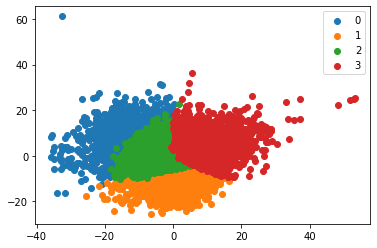

In [ ]:
for i in u_clusters:
    plt.scatter(df_scores.loc[np.where(clusters == i),'PC1'] , df_scores.loc[np.where(clusters == i),'PC2'], label = int(i) )
plt.legend()
plt.show()

### 2.3.2 Find an optimal number of clusters.
Use at least two different methods. In case that your algorithms provide different optimal K's, select one of them and explain why you chose it.

To choose the right number of clusters we decided to use the Elbow Method and the Silhouette Method.

#### Elbow Method
We compute the inertia for different values of k

The Elbow Method consist in plotting the values of the Inertia (or Within-Cluster Sum of Square) produced by different values of k. The Inertia is the sum of squared distance between each point and the centroid in a cluster. When we analyze the graph we can see that the graph will rapidly change at a point and thus creating an elbow shape. The K value corresponding to this point is the optimal K.

In [ ]:
from tqdm import tqdm
import json
import pickle

We compute the kmeans for  different values of k (from 2 to 20) and we create a dictionary with the clusters and the centroids that correspond at each k value. We have chosen to run the algorithm with 250 iteratioins because we have seen that the average number of iterations that it takes to compute the kmeans is around 170.


In [ ]:
kmeans_dict ={}
for i in tqdm(range(2,21)):
    model = my_kmeans(df_scores,i,250)
    clusters = model[0]
    centroids = model[1]
    kmeans_dict.update({i:[clusters,centroids]})        

100%|██████████| 19/19 [3:51:35<00:00, 731.34s/it]   


In [ ]:
with open("kmeans.pkl", "wb") as tf:
    pickle.dump(kmeans_dict,tf)

Here we define a function that compute the Inertia given a data frame, the clusters' labels and the centroids. The Inertia is the sum of squared distance between each point and the centroid in a cluster.

In [ ]:
def inertia(df,clusters,centroids):
    
    inertia = 0
    for i in range(len(df)):
        for j in range(len(df.iloc[0])):
            inertia += (df.iloc[i][j] - centroids[clusters[i]][j])**2
            
    return inertia           

We compute the inertia for the different results of the kmeans that we have computed before and we save them in a dictionary 

In [ ]:
inertia_dict = {} 
for i in tqdm(range(2,21)):
    clusters = kmeans_dict.get(i)[0]
    centroids = kmeans_dict.get(i)[1]
    inertia_dict.update({i:inertia(df_scores,clusters,centroids)})

100%|██████████| 19/19 [18:09<00:00, 57.35s/it]


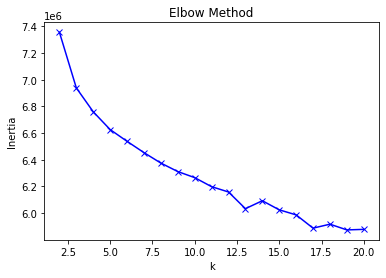

In [ ]:
#We plot the values of the Inertia 
plt.plot(range(2,21), inertia_dict.values(), 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In this plot we can clearly see that the elbow corresponds to the value of k of 13

In [ ]:
tf = open("inertia.json", "w")
json.dump(inertia_dict,tf)
tf.close()

#### Silhouette Method

The silhouette value is a measure of how similar an object is to its own clusterc compared to other clusters. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
A high average silhouette width indicates a good clustering. The average silhouette method computes the average silhouette of observations for different values of k. The optimal number of clusters k is the one that maximizes the average silhouette over a range of possible values for k

In [ ]:
from sklearn.metrics import silhouette_score

We compute the average silhoette score for the different results of the kmeans that we have computed before and we save them in a dictionary

In [ ]:
silhouette_dict = {}
for i in tqdm(range(2,21)):
    clusters = kmeans_dict.get(i)[0]
    silhouette_dict.update({i:silhouette_score(df_scores, clusters)})

100%|██████████| 19/19 [00:34<00:00,  1.81s/it]


In [ ]:
tf = open("silhouette.json", "w")
json.dump(silhouette_dict,tf)
tf.close()

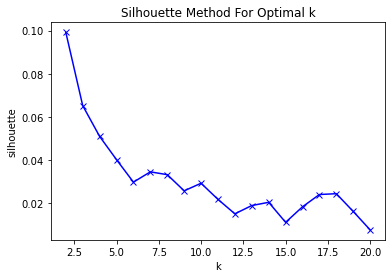

In [ ]:
#we plot the values of the silhouette score to analyse them
plt.plot(range(2,21), silhouette_dict.values(), 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('Silhouette Method For Optimal k')
plt.show()

In this plot we can see that the values of the average silhouette fluctuate a lot. The higher value of the silhouette score corresponds to the value of k equals to 2, so this method says to choose two clusters.

#### Which value of k do we choose?

Since the two methods gives two different results we choose the one that is more suitable for our analysis. Our final goal is to group songs into similar genres so we think that two clusters are not enough,instead 13 clusters is a results more convincing for our aim. 

### 2.3.3 Run the algorithm on the data that you got from the dimensionality reduction
All the runs are saved into the kmeans_dict that we've already stored into a pickle file in order to easily retrieve the run with 13 cluster when needed for further analysis


 ### 2.3.4 Use the already implemented version of k-means++
 (from the scikit-learn library). Explain the differences (if there are any) in the results.

In [ ]:
from sklearn.cluster import KMeans

We use the already implemented version of KMeans++ and we compute the inertia and the silhouette to choose the number of clusters with this version of the KMeans

In [ ]:
elbow = []
silhouette_dict_pp = {}
for k in tqdm(range(2,21)):
    model_pp = KMeans(n_clusters = k)
    model_pp.fit(df_scores)
    clusters_pp = model_pp.labels_
    elbow.append(model_pp.inertia_)
    silhouette_dict_pp.update({k:silhouette_score(df_scores, clusters_pp)})

100%|██████████| 19/19 [00:53<00:00,  2.84s/it]


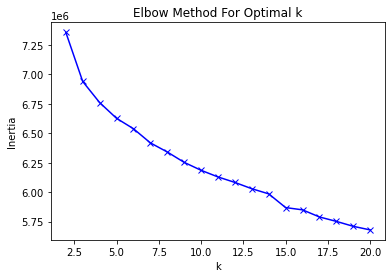

In [ ]:
plt.plot(range(2,21), elbow, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

As we can see the elbow corresponds to a value of k of 15.

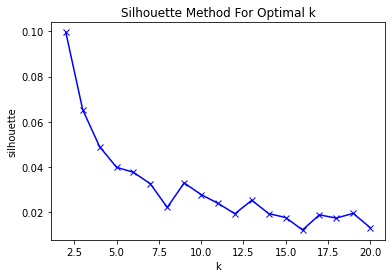

In [ ]:
plt.plot(range(2,21), silhouette_dict_pp.values(), 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('Silhouette Method For Optimal k')
plt.show()

Also with this version of the kmeans the values of the silhouette fluctuate a lot and the max value correspond to 2 clusters.

From the previous results of the KMeans++ we can see that the inertia is pretty different from the one that we computed from our version of the kmeans. The silhouette instead is more similar and gives us the same result for the number of clusters.
The two algorithms do not give the same results because they work in different ways. K-means starts with allocating initial cluster centers randomly, since these selection is random, the centroids can be selected really badly. K-means++ starts with the allocation of one cluster center randomly and then searches for other centers given the first one spreading the initial centers evenly.

Since the Kmeans choose the initial cluster centers randomly it can givs different results in different runs.

## 2.4 Analysing your results!

### 2.4.1 Select 5-10 variables (from the ones that you had before doing the dimensionality reduction step) you think are relevant to identify the genre of a song. For example, Duration, Language, Country, etc.

In [181]:
import pandas as pd

In [182]:
len(df.select_dtypes(include='object').columns)

40

- We've selected the most significant features for genres recognition, actually the very ones echonest itself created for building playlist for spotify, and some other important features.

In [183]:
features = ['metadata_artist_location',
           'track_language_code',
           'track_duration',
           'audio_features_acousticness',
           'audio_features_danceability',
           'audio_features_energy',
           'audio_features_instrumentalness',
           'audio_features_speechiness',
           'audio_features_tempo',
           'audio_features_valence']

- Once we chose our features it's time to categorize the numerical one (both float and int) into 4 categories:


except for the very first two features the other are numerical, let's categorize

In [184]:
df[features]

,metadata_artist_location,track_language_code,track_duration,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_speechiness,audio_features_tempo,audio_features_valence
0,"Georgia, US",en,168,0.416675,0.675894,0.634476,0.010628,0.159310,165.922,0.576661
1,"Georgia, US",en,237,0.374408,0.528643,0.817461,0.001851,0.461818,126.957,0.269240
2,"Georgia, US",en,206,0.043567,0.745566,0.701470,0.000697,0.124595,100.260,0.621661
3,"Philadelphia, PA, US",en,161,0.951670,0.658179,0.924525,0.965427,0.032985,111.562,0.963590
4,"Georgia, US",en,207,0.452217,0.513238,0.560410,0.019443,0.525519,114.290,0.894072
...,...,...,...,...,...,...,...,...,...,...
13124,Netherlands,NaN,268,0.007592,0.790364,0.719288,0.853114,0.082550,141.332,0.890461
13125,Netherlands,NaN,244,0.041498,0.843077,0.536496,0.865151,0.074001,101.975,0.476845
13126,Netherlands,NaN,382,0.000124,0.609686,0.895136,0.846624,0.051517,129.996,0.496667
13127,Netherlands,NaN,290,0.327576,0.574426,0.548327,0.452867,0.033388,142.009,0.569274


In [185]:
num_features = ['track_duration',
           'audio_features_acousticness',
           'audio_features_danceability',
           'audio_features_energy',
           'audio_features_instrumentalness',
           'audio_features_speechiness',
           'audio_features_tempo',
           'audio_features_valence']

### 2.4.2 categorize
If any of your selected variables are numerical (continuous or discrete), then categorize them into 4 categories

In [186]:
def categorize(features, df):
    cat = pd.DataFrame()
    for i in tqdm(range(0,len(features))):
        cat[ features[i] ] = pd.DataFrame({ features[i] : df[features[i]]})
        cat[ features[i] +' categorized'] = pd.cut(df[features[i]], 4)
        cat.sort_values(features[i] +' categorized')
        
    return cat
    

In [187]:
cat = categorize(num_features, df)

100%|██████████| 8/8 [00:00<00:00, 107.56it/s]


Let's sort them for the sake of clarity

In [188]:
cat_sort = cat.sort_values([i for i in cat.columns])
cat_sort

,track_duration,track_duration categorized,audio_features_acousticness,audio_features_acousticness categorized,audio_features_danceability,audio_features_danceability categorized,audio_features_energy,audio_features_energy categorized,audio_features_instrumentalness,audio_features_instrumentalness categorized,audio_features_speechiness,audio_features_speechiness categorized,audio_features_tempo,audio_features_tempo categorized,audio_features_valence,audio_features_valence categorized
8380,18,"(14.985, 771.75]",0.217487,"(-0.000995, 0.249]",0.604239,"(0.51, 0.739]",0.105663,"(-0.00098, 0.25]",8.230147e-01,"(0.749, 0.998]",0.038193,"(0.0214, 0.258]",59.914,"(12.515, 72.333]",0.054982,"(-0.00099, 0.25]"
2076,22,"(14.985, 771.75]",0.995075,"(0.747, 0.996]",0.572680,"(0.51, 0.739]",0.135195,"(-0.00098, 0.25]",6.000000e-10,"(-0.000998, 0.25]",0.964073,"(0.73, 0.966]",192.898,"(191.492, 251.072]",0.933745,"(0.75, 1.0]"
1548,31,"(14.985, 771.75]",0.090845,"(-0.000995, 0.249]",0.388385,"(0.281, 0.51]",0.677584,"(0.5, 0.75]",9.011276e-01,"(0.749, 0.998]",0.029079,"(0.0214, 0.258]",87.476,"(72.333, 131.913]",0.630784,"(0.5, 0.75]"
4842,31,"(14.985, 771.75]",0.191255,"(-0.000995, 0.249]",0.571785,"(0.51, 0.739]",0.004732,"(-0.00098, 0.25]",1.551058e-04,"(-0.000998, 0.25]",0.469730,"(0.258, 0.494]",88.073,"(72.333, 131.913]",0.270144,"(0.25, 0.5]"
4864,31,"(14.985, 771.75]",0.630930,"(0.498, 0.747]",0.275260,"(0.0504, 0.281]",0.006120,"(-0.00098, 0.25]",7.300000e-09,"(-0.000998, 0.25]",0.064057,"(0.0214, 0.258]",61.714,"(12.515, 72.333]",0.498482,"(0.25, 0.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,2923,"(2279.25, 3033.0]",0.977487,"(0.747, 0.996]",0.296389,"(0.281, 0.51]",0.342213,"(0.25, 0.5]",8.007759e-01,"(0.749, 0.998]",0.078140,"(0.0214, 0.258]",80.845,"(72.333, 131.913]",0.138683,"(-0.00099, 0.25]"
2298,2926,"(2279.25, 3033.0]",0.551999,"(0.498, 0.747]",0.510412,"(0.51, 0.739]",0.417033,"(0.25, 0.5]",2.935389e-01,"(0.25, 0.499]",0.157200,"(0.0214, 0.258]",89.078,"(72.333, 131.913]",0.565640,"(0.5, 0.75]"
6054,2940,"(2279.25, 3033.0]",0.792378,"(0.747, 0.996]",0.211954,"(0.0504, 0.281]",0.427827,"(0.25, 0.5]",8.257631e-01,"(0.749, 0.998]",0.047388,"(0.0214, 0.258]",144.963,"(131.913, 191.492]",0.182074,"(-0.00099, 0.25]"
7337,3016,"(2279.25, 3033.0]",0.747580,"(0.747, 0.996]",0.374019,"(0.281, 0.51]",0.389284,"(0.25, 0.5]",7.862765e-03,"(-0.000998, 0.25]",0.109553,"(0.0214, 0.258]",86.924,"(72.333, 131.913]",0.486147,"(0.25, 0.5]"


In [189]:
ct_duration , ct_acousticness , ct_danceability = pd.DataFrame() , pd.DataFrame() , pd.DataFrame()
ct_energy , ct_instrumentalness , ct_speechiness  = pd.DataFrame() , pd.DataFrame() , pd.DataFrame()
ct_tempo , ct_valence = pd.DataFrame() , pd.DataFrame()

ct_duration['track_duration categorized'] = cat['track_duration categorized'].value_counts().sort_index()
ct_acousticness['audio_features_acousticness categorized'] = cat['audio_features_acousticness categorized'].value_counts().sort_index()
ct_danceability['audio_features_danceability categorized'] = cat['audio_features_danceability categorized'].value_counts().sort_index()
ct_energy['audio_features_energy categorized'] = cat['audio_features_energy categorized'].value_counts().sort_index()
ct_instrumentalness['audio_features_instrumentalness categorized'] = cat['audio_features_instrumentalness categorized'].value_counts().sort_index()
ct_speechiness['audio_features_speechiness categorized'] = cat['audio_features_speechiness categorized'].value_counts().sort_index()
ct_tempo['audio_features_tempo categorized'] = cat['audio_features_tempo categorized'].value_counts().sort_index()
ct_valence['audio_features_valence categorized'] = cat['audio_features_valence categorized'].value_counts().sort_index()

ct_box = [ct_duration , ct_acousticness , ct_danceability , 
          ct_energy , ct_instrumentalness , ct_speechiness ,
          ct_tempo , ct_valence]

for i in ct_box:
    display(i)

,track_duration categorized
"(14.985, 771.75]",12905
"(771.75, 1525.5]",137
"(1525.5, 2279.25]",56
"(2279.25, 3033.0]",31


,audio_features_acousticness categorized
"(-0.000995, 0.249]",4482
"(0.249, 0.498]",1597
"(0.498, 0.747]",1720
"(0.747, 0.996]",5330


,audio_features_danceability categorized
"(0.0504, 0.281]",2070
"(0.281, 0.51]",5050
"(0.51, 0.739]",4584
"(0.739, 0.969]",1425


,audio_features_energy categorized
"(-0.00098, 0.25]",2472
"(0.25, 0.5]",3296
"(0.5, 0.75]",3748
"(0.75, 1.0]",3613


,audio_features_instrumentalness categorized
"(-0.000998, 0.25]",3062
"(0.25, 0.499]",756
"(0.499, 0.749]",1378
"(0.749, 0.998]",7933


,audio_features_speechiness categorized
"(0.0214, 0.258]",11972
"(0.258, 0.494]",769
"(0.494, 0.73]",229
"(0.73, 0.966]",159


,audio_features_tempo categorized
"(12.515, 72.333]",654
"(72.333, 131.913]",7660
"(131.913, 191.492]",4340
"(191.492, 251.072]",475


,audio_features_valence categorized
"(-0.00099, 0.25]",4103
"(0.25, 0.5]",3621
"(0.5, 0.75]",3154
"(0.75, 1.0]",2251


3. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

In [190]:
# retrieving the clusters from the stored model obtained in 2.3.3
import pickle
f = open('data/kmeans.pkl', 'rb')
kmeans_result = pickle.load(f) # format = {k: [clusters, centroids]}
f.close()

In [191]:
import numpy as np

clusters = kmeans_result[13][0]

In [192]:
df.loc[clusters == 0]['track_duration']

14       319
35        68
281      338
350      489
353      177
        ... 
11948    136
12460    365
12702     88
12731     82
12836     59
Name: track_duration, Length: 144, dtype: int64

In [193]:
cat_sort['track_duration categorized']

8380     (14.985, 771.75]
2076     (14.985, 771.75]
1548     (14.985, 771.75]
4842     (14.985, 771.75]
4864     (14.985, 771.75]
              ...        
8212    (2279.25, 3033.0]
2298    (2279.25, 3033.0]
6054    (2279.25, 3033.0]
7337    (2279.25, 3033.0]
1516    (2279.25, 3033.0]
Name: track_duration categorized, Length: 13129, dtype: category
Categories (4, interval[float64, right]): [(14.985, 771.75] < (771.75, 1525.5] < (1525.5, 2279.25] < (2279.25, 3033.0]]

In [194]:
prova_track_duration = pd.DataFrame()
prova_track_duration['track_duration'] = cat['track_duration']
prova_track_duration['cluster'] = clusters
min(prova_track_duration['track_duration'])

18

### 2.4.3-4 Let's Pivot
With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

Calculate the percentage by column for each pivot table. It means that the sum of each column (cluster) must be 1

In [195]:
# Adding the percentage cluster columns to perform the pivots
new_df = cat.copy()
for i in np.unique(clusters):
    new_df.loc[:,f'cluster {str(i).zfill(2)}'] = (clusters==i)/(sum(clusters==i))

In [197]:
# importing the modules
from IPython.display import display
tab_box= []
for i in cat_sort:
    if 'categorized' in i:
        display(pd.pivot_table(new_df, index= i, values=[f'cluster {str(i).zfill(2)}' for i in np.unique(clusters)], margins=True, aggfunc='sum'))
        

,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
track_duration categorized,,,,,,,,,,,,,
"(14.985, 771.75]",0.993056,0.934315,0.992429,0.946281,0.992593,0.989583,0.981865,1.0,0.994555,0.978552,0.986175,0.997159,0.998733
"(771.75, 1525.5]",0.006944,0.037373,0.005824,0.028926,0.004762,0.008814,0.012953,0.0,0.004537,0.005362,0.011521,0.000710,0.000000
"(1525.5, 2279.25]",0.000000,0.021518,0.001165,0.011570,0.001587,0.000801,0.003627,0.0,0.000907,0.010724,0.002304,0.002131,0.001267
"(2279.25, 3033.0]",0.000000,0.006795,0.000582,0.013223,0.001058,0.000801,0.001554,0.0,0.000000,0.005362,0.000000,0.000000,0.000000
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
audio_features_acousticness categorized,,,,,,,,,,,,,
"(-0.000995, 0.249]",0.152778,0.007928,0.184624,0.340496,0.335979,0.093750,0.274611,0.0,0.779492,0.541555,0.006912,0.741477,0.423321
"(0.249, 0.498]",0.062500,0.007928,0.090856,0.150413,0.204233,0.063301,0.147150,0.0,0.134301,0.211796,0.000000,0.123580,0.117871
"(0.498, 0.747]",0.069444,0.023783,0.166570,0.134711,0.210582,0.122596,0.176166,0.0,0.056261,0.120643,0.002304,0.087358,0.149556
"(0.747, 0.996]",0.715278,0.960362,0.557950,0.374380,0.249206,0.720353,0.402073,1.0,0.029946,0.126005,0.990783,0.047585,0.309252
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
audio_features_danceability categorized,,,,,,,,,,,,,
"(0.0504, 0.281]",0.381944,0.238958,0.278975,0.037190,0.048148,0.144231,0.116580,1.0,0.017241,0.085791,0.188940,0.250000,0.377693
"(0.281, 0.51]",0.354167,0.519819,0.508445,0.232231,0.275661,0.476763,0.402073,0.0,0.129764,0.284182,0.566820,0.487926,0.395437
"(0.51, 0.739]",0.229167,0.224236,0.199767,0.458678,0.513757,0.349359,0.429016,0.0,0.417423,0.450402,0.228111,0.250710,0.177440
"(0.739, 0.969]",0.034722,0.016988,0.012813,0.271901,0.162434,0.029647,0.052332,0.0,0.435572,0.179625,0.016129,0.011364,0.049430
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
audio_features_energy categorized,,,,,,,,,,,,,
"(-0.00098, 0.25]",0.722222,0.862967,0.032033,0.214050,0.014815,0.322917,0.216580,1.0,0.065336,0.002681,0.744240,0.004261,0.050697
"(0.25, 0.5]",0.236111,0.121178,0.182877,0.388430,0.197884,0.443109,0.436788,0.0,0.310345,0.085791,0.230415,0.049716,0.072243
"(0.5, 0.75]",0.034722,0.013590,0.415259,0.285124,0.420635,0.201923,0.292228,0.0,0.404719,0.233244,0.025346,0.249290,0.211660
"(0.75, 1.0]",0.006944,0.002265,0.369831,0.112397,0.366667,0.032051,0.054404,0.0,0.219601,0.678284,0.000000,0.696733,0.665399
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
audio_features_instrumentalness categorized,,,,,,,,,,,,,
"(-0.000998, 0.25]",0.020833,0.240091,0.105416,0.359504,0.403175,0.217949,0.257513,0.0,0.100726,0.203753,0.158986,0.247869,0.120406
"(0.25, 0.499]",0.020833,0.048698,0.054747,0.066942,0.073016,0.060096,0.061658,0.0,0.034483,0.072386,0.027650,0.057528,0.057034
"(0.499, 0.749]",0.041667,0.084938,0.106581,0.120661,0.113757,0.095353,0.102073,0.0,0.079855,0.203753,0.029954,0.127841,0.101394
"(0.749, 0.998]",0.916667,0.626274,0.733256,0.452893,0.410053,0.626603,0.578756,1.0,0.784936,0.520107,0.783410,0.566761,0.721166
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
audio_features_speechiness categorized,,,,,,,,,,,,,
"(0.0214, 0.258]",0.965278,0.984145,0.986605,0.722314,0.792063,0.991987,0.984456,1.0,0.847550,0.839142,0.864055,0.987216,0.948035
"(0.258, 0.494]",0.020833,0.011325,0.011066,0.142149,0.150794,0.007212,0.012953,0.0,0.116152,0.128686,0.064516,0.011364,0.032953
"(0.494, 0.73]",0.006944,0.003398,0.002330,0.064463,0.043386,0.000801,0.002591,0.0,0.025408,0.013405,0.023041,0.001420,0.012674
"(0.73, 0.966]",0.006944,0.001133,0.000000,0.071074,0.013757,0.000000,0.000000,0.0,0.010889,0.018767,0.048387,0.000000,0.006337
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
audio_features_tempo categorized,,,,,,,,,,,,,
"(12.515, 72.333]",0.083333,0.154020,0.028538,0.067769,0.035979,0.063301,0.051813,0.0,0.034483,0.034853,0.082949,0.012074,0.030418
"(72.333, 131.913]",0.652778,0.646659,0.499709,0.602479,0.585185,0.646635,0.626943,0.0,0.637024,0.525469,0.649770,0.506392,0.496831
"(131.913, 191.492]",0.222222,0.175538,0.442632,0.271901,0.338095,0.265224,0.296373,1.0,0.286751,0.410188,0.235023,0.448153,0.404309
"(191.492, 251.072]",0.041667,0.023783,0.029121,0.057851,0.040741,0.024840,0.024870,0.0,0.041742,0.029491,0.032258,0.033381,0.068441
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
audio_features_valence categorized,,,,,,,,,,,,,
"(-0.00099, 0.25]",0.812500,0.605889,0.284799,0.261983,0.133333,0.395833,0.406736,1.0,0.258621,0.206434,0.168203,0.236506,0.437262
"(0.25, 0.5]",0.104167,0.237826,0.284217,0.271074,0.245503,0.295673,0.291192,0.0,0.298548,0.254692,0.317972,0.311080,0.234474
"(0.5, 0.75]",0.041667,0.100793,0.251019,0.293388,0.333862,0.175481,0.192746,0.0,0.278584,0.254692,0.283410,0.272017,0.181242
"(0.75, 1.0]",0.041667,0.055493,0.179965,0.173554,0.287302,0.133013,0.109326,0.0,0.164247,0.284182,0.230415,0.180398,0.147022
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.4.6 Versus reality
Now, it's time to compare the obtained clusters to the reality genre. Us it to answer what is the most representative genre for each one of the clusters?. You can answer this using the same methodology proposed in step 4th

In [198]:
new_df.loc[:, 'track_genre_top'] = df.loc[:, 'track_genre_top']

In [199]:
display(pd.pivot_table(new_df, index= 'track_genre_top', values=[f'cluster {str(i).zfill(2)}' for i in np.unique(clusters)], margins=True, aggfunc='sum'))

,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12
track_genre_top,,,,,,,,,,,,,
Blues,0.000000,0.010193,0.006407,0.004959,0.003704,0.011218,0.009326,0.0,0.000907,0.000000,0.000000,0.000000,0.000000
Classical,0.062500,0.227633,0.004659,0.002479,0.002646,0.017628,0.004145,0.0,0.000000,0.000000,0.020737,0.000000,0.000000
Electronic,0.229167,0.080408,0.041351,0.280165,0.185714,0.061699,0.101036,1.0,0.463702,0.694370,0.006912,0.093750,0.160963
Experimental,0.000000,0.002265,0.000000,0.001653,0.000529,0.000801,0.001036,0.0,0.000907,0.002681,0.004608,0.002841,0.001267
Folk,0.159722,0.156285,0.052999,0.022314,0.011640,0.241987,0.102073,0.0,0.009982,0.000000,0.078341,0.012074,0.015209
Hip-Hop,0.034722,0.002265,0.013978,0.114876,0.243915,0.008814,0.022280,0.0,0.142468,0.005362,0.000000,0.019176,0.049430
Instrumental,0.006944,0.010193,0.004659,0.008264,0.005291,0.008013,0.013990,0.0,0.000000,0.000000,0.002304,0.002841,0.005070
International,0.020833,0.015855,0.009901,0.009917,0.010582,0.030449,0.005699,0.0,0.000000,0.002681,0.011521,0.002841,0.010139
Jazz,0.000000,0.056625,0.011066,0.030579,0.016402,0.024038,0.027979,0.0,0.001815,0.002681,0.006912,0.004261,0.010139


### 2.4.5 Interpret the results for each pivot table


After we created all the pivot tables for each pair (genre , cluster) it is possible to analyze them:

As it is possible to see the tables represent the percentage of the genre identificated for data that lies in a specific cluster. 

As a benchmark for our analysis we consider 12 top genres:

1. Blues

It originated from the amateur music of poor black slaves in the south of the United States in the past. It had no accompaniment, but a solo singing with emotional content, and later combined with the European chord structure to form music of singing and guitar alternately. The blues are based on the pentatonic scale, which is composed of five scales arranged in pure fifths.

2. Classical

It is the traditional musical art of Western music, and it is music created under the background of mainstream European culture. The most prominent feature of classical music is that its works generally use notation to record the score, so that the rhythm and pitch can be recorded in detail, and it is also conducive to the direct coordination of multiple performers. Many types of musical instruments are used in classical music, including woodwind, brass, percussion, keyboard, bowed, and plucked stringed instruments.

3. Jazz

It originated from the blues, combining and absorbing classical music, folk music, and other musical styles on the basis of African music traditions, and gradually formed today’s diverse jazz music.

4. Country

It originated in the southern United States. It is a kind of popular music with ethnic characteristics. The main characteristics of country music are its simple tune, steady rhythm, being mainly narrative, and a strong local flavor, mostly in the form of ballads, with body, two-part, or three-part form. Country music is mostly solo or chorus, with harmonica, guitar, violin, and other accompaniment. The themes of country music are generally love, country life, cowboy humor, family, God, and country.

5. Rock

It originated in the mid-1950s and was developed under the influence of blues and country music. It is characterized by prominent vocals and played with guitar, bass, and drum accompaniment, and keyboard instruments such as electronic organs, organs, and pianos are often used. Rock music has a strong beat, centered on various guitar sounds.

6. Metal

It is a kind of rock music, which was developed in Britain and the United States in its early days. Metal music has the characteristics of high explosive power, weight, and speed. Its weight is reflected in the low scale of electric guitars and point bass. The speed is reflected in the beat, the beat of metal music can reach more than 200 BPM, and the beat range of general pop music is only 80–130 BPM. The core instruments of metal music are electric guitar, electric bass, and drums, which control the rhythm and melody.

7. Disco

It is a kind of electronic music, which originated from African American folk dance and jazz dance. In rhythm, the characteristics of rock music, jazz, and Latin American music are mixed. As ballroom music, disco is characterized by a strong sense of rhythm, arranged by lively string music. Disco is generally 4/4 shots, and every shot is strong, about 120 BPM.

8. Pop

It originated in Britain and the United States in the mid-1950s. Popular music is eclectic, often borrowing elements of other styles of music. But pop music also has its core elements: its structure is relatively short, usually about three minutes.

9. Hip-Hop

It originated in New York, USA, when it was popular among African Americans and neighborhood gatherings. Hip-hop consists of two main components: rap and DJing. The performer sings in the way of saying words according to the rhythm of the instrument or synthesis.

10. Reggae

It is derived from the popular music of Ska and Rock Steady, which evolved in Jamaica. It is the general term for various dance music in Jamaica.

11. Electronic

It is a kind of music made using electronic musical instruments and electronic technology. In electronic music, a variety of genres are often combined, and they are modulated into unique timbres through electronic musical instruments and synthesizers to form a unique style. Commonly used electronic musical instruments include electric guitars, electric basses, synthesizers, and electronic organs.

12. Punk

It is simple rock music derived from Garage Rock and pre-punk rock, consisting of three chords and a simple main melody.



although we do know music changes during time and genres influence eachother:

<img src="clusters.png" width=600 height=350 />





For what concerns our results it is possible to interpret the table by looking at the different genres and confront them with the the matching cluster which will tell the amount of data that matches with a specific genres and lies in a specific cluster. Although it is easy to see that the marginal sum of the amount of data doesn't sums to one as well as cluster n.7 is empty. This is due to the Nan values we chose to drop.
Another observation is that data usually lies in intersection of cluster this results in mixed genres for the data just as we expected.


### 2.4.7 Execute your K-means++ Analysis again
but don't use the variables from **echonest.csv**. It will leave you with ~100K songs. Focus on getting the following results:
    - Perform the dimensionality reduction.
    - Find the optimal number of clusters.
    - Characterize your clusters using 5-10 variables.
	- Compare your results with those of the previous exercise. If you could choose, would you rather collect more observations (with fewer features) or fewer observations (with more features) based on the previous analyses?

We decided to use the PCA to do the dimensinality reduction and now that we have chosen the features on which to do the pca we can start.
It's important to notice that actually the dataframe from which we'll take the values is already stored without the deleted cells of the first pca (point 2.2) So we'll go directly into the standardization

In [200]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

The first thing to do for the PCA is to standardise the data, in this way they will have mean = 0 and s.d. = 1.

In [ ]:
df_no_echo = pd.read_csv('data/csv/feat_tracks_dataset.csv', header='infer') # Sice we've already cleaned the dataset from the unwanted columns
# We directly start from PCA

scaler = StandardScaler()
X = scaler.fit_transform(df_no_echo) #data scaling
pca = decomposition.PCA(n_components = 0.80) # we choose the number of principal components that explains the 80% of the total variance
pca.fit(X)
X_transformed = pca.transform(X)
print(X_transformed.shape)
columns = ['PC'+str(i) for i in range(1,X_transformed.shape[1]+1)]
df_no_echo_scores = pd.DataFrame(pca.transform(X), columns = columns)
df_no_echo_scores.head()

OSS: Now we've less component as before and this is surely due to the fact that the number of colums is decisely lower (more than 200 columns)

In [127]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

models_kpp = [KMeans(n_clusters=k).fit(df_no_echo_scores) for k in tqdm(range(2,21))]
elbow_kpp = [m.inertia_ for m in models_kpp]
silhouette_dict_kpp = {i:silhouette_score(df_no_echo_scores, models_kpp[i].labels_) for i in range(len(models_kpp))}

100%|██████████| 19/19 [02:45<00:00,  8.69s/it]


In [130]:
import json

tf = open("silhouette_kpp.json", "w")
json.dump(silhouette_dict_kpp,tf)
tf.close()

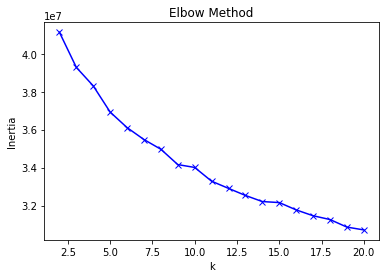

In [202]:
import matplotlib.pyplot as plt

plt.plot(range(2,21), elbow_kpp, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

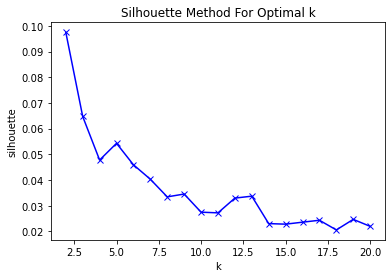

In [203]:
plt.plot(range(2,21), silhouette_dict_kpp.values(), 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('Silhouette Method For Optimal k')
plt.show()

#### Analysis
The shape of the graphs are the same of the above run, even the elbow seems to be around the value of k=13, let's dig into the pivot table to understand what's different

In [204]:
from IPython.display import display

tracks = pd.read_csv('data/csv/tracks.csv', header='infer')

col_of_interest = ['artist_comments','artist_favorites', 'track_bit_rate', 'track_comments','track_favorites', 'track_interest', 'track_listens']

df_no_echo_cat = categorize(col_of_interest, df_no_echo)
df_no_echo_cat['track_genre_top'] = tracks['track_genre_top']


clusters_kpp = models_kpp[13].labels_ 

for i in np.unique(clusters_kpp):
    df_no_echo_cat.loc[:,f'cluster {str(i).zfill(2)}'] = (clusters_kpp==i)/(sum(clusters_kpp==i))

for col in col_of_interest:
    idx = col +' categorized'
    display(pd.pivot_table(df_no_echo_cat, index=idx, values=[f'cluster {str(i).zfill(2)}' for i in np.unique(clusters_kpp)], margins=True, aggfunc='sum'))

100%|██████████| 7/7 [00:00<00:00, 96.83it/s]


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
artist_comments categorized,,,,,,,,,,,,,,,
"(-1.08, 19.0]",0.990779,0.995094,0.939280,0.993251,0.989397,1.0,0.987540,0.976123,0.965776,0.8,0.979658,0.965732,0.982301,0.965102,0.950174
"(19.0, 39.0]",0.005044,0.002878,0.046790,0.005812,0.009088,0.0,0.008838,0.016651,0.025588,0.2,0.017079,0.018876,0.013274,0.022856,0.049054
"(39.0, 59.0]",0.002364,0.001962,0.009644,0.000750,0.001388,0.0,0.002753,0.003456,0.003998,0.0,0.002399,0.012638,0.000000,0.009585,0.000772
"(59.0, 79.0]",0.001813,0.000065,0.004286,0.000187,0.000126,0.0,0.000869,0.003770,0.004638,0.0,0.000864,0.002754,0.004425,0.002458,0.000000
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
artist_favorites categorized,,,,,,,,,,,,,,,
"(-1.964, 240.0]",0.991724,0.995356,0.916778,0.996438,0.991859,1.0,0.989858,0.965127,0.971694,1.0,0.978603,0.947181,0.980088,0.952814,0.948629
"(240.0, 481.0]",0.002128,0.002159,0.047147,0.002250,0.004418,0.0,0.003767,0.017908,0.012634,0.0,0.005949,0.026248,0.011062,0.018924,0.022016
"(481.0, 722.0]",0.000473,0.000392,0.004733,0.000375,0.001388,0.0,0.000290,0.005027,0.004158,0.0,0.000096,0.004537,0.004425,0.005407,0.000000
"(722.0, 963.0]",0.005675,0.002093,0.031342,0.000937,0.002335,0.0,0.006085,0.011938,0.011514,0.0,0.015352,0.022035,0.004425,0.022856,0.029355
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
track_bit_rate categorized,,,,,,,,,,,,,,,
"(-449.001, 111999.25]",0.010404,0.008242,0.015537,0.029059,0.017861,0.0,0.009128,0.014452,0.024628,0.0,0.012186,0.005752,0.008850,0.011059,0.029741
"(111999.25, 223999.5]",0.234789,0.258961,0.294848,0.275591,0.294415,0.0,0.195016,0.260760,0.324004,0.0,0.266456,0.244167,0.227876,0.274023,0.190035
"(223999.5, 335999.75]",0.754808,0.732797,0.689615,0.695163,0.687725,1.0,0.795711,0.724788,0.651367,1.0,0.721359,0.750081,0.763274,0.714918,0.779838
"(335999.75, 448000.0]",0.000000,0.000000,0.000000,0.000187,0.000000,0.0,0.000145,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000386
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
track_comments categorized,,,,,,,,,,,,,,,
"(-0.037, 9.25]",1.0,0.999935,0.999643,0.999813,1.0,1.0,0.999855,1.0,1.0,1.0,1.0,0.999757,1.0,0.999508,1.0
"(9.25, 18.5]",0.0,0.000065,0.000357,0.000000,0.0,0.0,0.000145,0.0,0.0,0.0,0.0,0.000081,0.0,0.000246,0.0
"(18.5, 27.75]",0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000162,0.0,0.000000,0.0
"(27.75, 37.0]",0.0,0.000000,0.000000,0.000187,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000246,0.0
All,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
track_favorites categorized,,,,,,,,,,,,,,,
"(-1.482, 370.5]",0.999921,1.0,0.999107,1.0,0.999937,1.0,0.999855,1.0,0.99968,1.0,1.0,0.999595,1.0,0.999017,1.0
"(370.5, 741.0]",0.000079,0.0,0.000804,0.0,0.000063,0.0,0.000145,0.0,0.00032,0.0,0.0,0.000324,0.0,0.000492,0.0
"(741.0, 1111.5]",0.000000,0.0,0.000089,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000081,0.0,0.000246,0.0
"(1111.5, 1482.0]",0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000246,0.0
All,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.00000,1.0,1.0,1.000000,1.0,1.000000,1.0


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
track_interest categorized,,,,,,,,,,,,,,,
"(-3291.555, 823390.75]",1.0,1.0,0.999732,1.0,1.0,1.0,0.999855,0.999686,0.99984,1.0,1.0,0.999919,1.0,0.999754,1.0
"(823390.75, 1646779.5]",0.0,0.0,0.000268,0.0,0.0,0.0,0.000145,0.000314,0.00016,0.0,0.0,0.000000,0.0,0.000000,0.0
"(1646779.5, 2470168.25]",0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000081,0.0,0.000000,0.0
"(2470168.25, 3293557.0]",0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000246,0.0
All,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.00000,1.0,1.0,1.000000,1.0,1.000000,1.0


,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
track_listens categorized,,,,,,,,,,,,,,,
"(-543.252, 135813.0]",0.999842,1.0,0.997857,0.999813,0.999748,1.0,0.999710,0.998743,0.9992,1.0,0.999712,0.999190,1.0,0.998034,1.0
"(135813.0, 271626.0]",0.000158,0.0,0.001518,0.000187,0.000189,0.0,0.000145,0.000628,0.0008,0.0,0.000288,0.000729,0.0,0.001475,0.0
"(271626.0, 407439.0]",0.000000,0.0,0.000357,0.000000,0.000063,0.0,0.000000,0.000628,0.0000,0.0,0.000000,0.000081,0.0,0.000246,0.0
"(407439.0, 543252.0]",0.000000,0.0,0.000268,0.000000,0.000000,0.0,0.000145,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000246,0.0
All,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0000,1.0,1.000000,1.000000,1.0,1.000000,1.0


In [177]:
display(pd.pivot_table(df_no_echo_cat, index='track_genre_top', values=[f'cluster {str(i).zfill(2)}' for i in np.unique(clusters_kpp)], margins=True, aggfunc='sum'))

,cluster 00,cluster 01,cluster 02,cluster 03,cluster 04,cluster 05,cluster 06,cluster 07,cluster 08,cluster 09,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14
track_genre_top,,,,,,,,,,,,,,,
Blues,0.000315,0.000065,0.001429,0.000000,0.002083,0.0,0.000290,0.000000,0.000480,0.0,0.001343,0.002106,0.000000,0.002212,0.000772
Classical,0.000552,0.000458,0.069738,0.000187,0.002966,0.0,0.000724,0.002828,0.021430,0.0,0.003070,0.003240,0.000000,0.007373,0.052916
Country,0.001025,0.002420,0.001786,0.000937,0.003724,0.0,0.000000,0.000000,0.000480,0.0,0.000864,0.003159,0.000000,0.002212,0.000000
Easy Listening,0.000236,0.000000,0.000179,0.000000,0.000316,0.0,0.000145,0.000628,0.000320,0.0,0.000384,0.000243,0.000000,0.000246,0.000386
Electronic,0.220681,0.042125,0.025449,0.090551,0.057305,0.0,0.142133,0.086396,0.035183,0.0,0.139033,0.074692,0.110619,0.051118,0.056779
Experimental,0.079997,0.060767,0.082865,0.189164,0.123761,1.0,0.132860,0.101791,0.133856,0.0,0.128382,0.051280,0.307522,0.070042,0.112785
Folk,0.002128,0.007915,0.083757,0.005812,0.024550,0.0,0.004491,0.028589,0.040301,0.0,0.009499,0.039128,0.008850,0.075940,0.010815
Hip-Hop,0.110183,0.014914,0.001875,0.017435,0.035090,0.0,0.048971,0.017279,0.003198,0.0,0.048455,0.024789,0.002212,0.007127,0.000772
Instrumental,0.004020,0.008307,0.044379,0.015561,0.010792,0.0,0.012750,0.041470,0.041260,0.0,0.012666,0.023898,0.011062,0.043991,0.023561


### Comparison
The elbow graph seems to be a little less smoothed and the inertia is as confused as for the previous cases, in my opinion its more convenient to have more features but less rows, looking to the language pivot in fact they are distributed in similar way, but in order to run the silhouette method over 100k rows we need very long times.<br>
Adding features means add dimensionality to our data space, instead adding rows means adding points, with more points can be more difficult to find the right classification of them, we need also to consider that the complexity of the algorithm is strongly dependent from the number of points, not features

## 3. Algorithmic questions

You are given a list of integers, *A*, and another integer *s*. Write an algorithm that outputs all the pairs in *A* that equal *x*.

For example, if
```
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] and s = 4
```
the algorithm should output: `(7, -3), (-2, 6), (2, 2), (3, 1)`.

In [ ]:
def sum_equal(A,s):
    pair = []
    for i in range (0 , len(A)):
        for j in range (0 , len(A)):
            if i != j and A[i]+A[j] == s:
                if (A[i],A[j]) not in pair and (A[j],A[i]) not in pair:
                    pair.append((A[i],A[j]))
    return print(*map(tuple,pair))
          
                

In [ ]:
sum_equal([7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3],4)

(7, -3) (-2, 6) (2, 2) (1, 3)


Even if the example asks for that specific query to return (3,1) instead of (1, 3) it shouldn't weight much also because it is more correct for what the task asked to compute the pair in order from left to right returning (3,1)
seems like (1,3) which comes firs had been wrongly discarded 